# Practica 1 Alfonso Ramos Rojas

## Carga de librerias

- **Numpy (np)**: operaciones numéricas y manipulación de arrays; aquí se usa para crear ventanas temporales (np.lib.stride_tricks.sliding_window_view) y cálculos vectorizados.
- **Pandas (pd)**: lectura y manejo de datos tabulares/series temporales (pd.read_csv, index datetime, selección de columnas).
- **Matplotlib.pyplot (plt)**: visualización de series temporales y marcado de anomalías (plot, scatter, show).
- **Tensorflow (tf)**: framework de deep learning y backend para Keras.
- **keras.models.Sequential**: contenedor secuencial para construir la RNN/modelo.
- **keras.layers.LSTM**: capa recurrente LSTM para modelado de dependencias temporales.
- **keras.layers.Dense**: capa densa/final para producir la predicción.

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Input, RepeatVector, TimeDistributed
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest

## 1. Contrucción de modelo LSTM y detección de anomalías

### a. Construcción del modelo básico

#### Cargar datos
Cargamos todo desde el csv de datos dado en el dataframe de pandas y escalamos los valores a un rango de [0,1], lo que mejorara la eficiencia de los modelos

In [117]:
df = pd.read_csv("datos.csv",parse_dates=True)
print("Datos cargados: \n", df.head(5))

Datos cargados: 
              timestamp      value
0  2013-07-04 00:00:00  69.880835
1  2013-07-04 01:00:00  71.220227
2  2013-07-04 02:00:00  70.877805
3  2013-07-04 03:00:00  68.959400
4  2013-07-04 04:00:00  69.283551


#### Creamos las ventanas temporales
Aquí el parametro principal es el tamaño de ventana, que varía mucho el resultado del modelo. En un principio probé con valores bajos (3, 5) y tras hacer pruebas, he descubierto que da mejores resultados tamaños medios de ventana de ventana. Primero con 24 daba mejores resultados, pero con 12 valores por ventana da los mejores resultados para nuestros datos.


In [118]:
n_steps = 12
windows = np.lib.stride_tricks.sliding_window_view(df["value"], window_shape=(n_steps))
print("Dimensiones de ventanas: ", windows.shape)

Dimensiones de ventanas:  (7256, 12)


#### Creamos datos de entrenamiento
Usamos como datos todas las ventanas menos la última para la predicción.
Para los valores objetivos usamos el primer valor siguiente a la ventana claro, que es el que puede predecir la primera ventana.
Además de eso redimensionamos las ventanas para que las acepte el modelo

In [119]:
X = windows[:-1]
y = df["value"].values[n_steps:]
X = X.reshape((X.shape[0], X.shape[1], 1))
print("X Shape: ", X.shape)
print("Y Shape: ", y.shape)

X Shape:  (7255, 12, 1)
Y Shape:  (7255,)


#### Creamos el modelo
Creamos el modelo, con una capa de LSTM unida con una capa densa de 1 neurona al final como salida.
En primer lugar, las neuronas de la capa LSTM dan mucho mejor resultado siendo 100 en vez de 50

Además la funcion de activación sigmoide da unos resultados muy superiores a la tanh

In [120]:
model = Sequential([
	LSTM(100, activation='sigmoid', input_shape=(n_steps, 1)),
	Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse')

c:\Cosas\CosasPython\Practicas-Software-Critico\Practica1\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### Entrenamos el modelo con las ventanas
Al principio usaba 50 epochs en el modelo, pensando que asi mejoraria mucho la calidad del modelo cuantos mas epochs use, sin embargo probando valores mas bajos, resulta que con tantisimos epochs se producia muchisimo sobre ajuste y además detectaba demasiados puntos como anomalías. Probando he encontrado que el numero óptimo de epochs es 15, manteniendo un mse medio final del modelo de aprox. 5

In [121]:
epochs = 15

history = model.fit(X, y, epochs=epochs, verbose=1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

print("Modelo entrenado exitosamente")

Epoch 1/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 3566.0942
Epoch 2/15
 15/227 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2631.2004

c:\Cosas\CosasPython\Practicas-Software-Critico\Practica1\venv\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2047.6497
Epoch 3/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1182.1469
Epoch 4/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 641.3282
Epoch 5/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 324.0606
Epoch 6/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 148.8493
Epoch 7/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 63.5845
Epoch 8/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 32.1984
Epoch 9/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 21.8073
Epoch 10/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 18.7887
Epoch 11/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 16.8746
Epoch 12/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 12.6362
Epoch 13/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 6.9422
Epoch 14/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4.1419
Epoch 15/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.0581
Modelo entrenado exitosamente


#### Graficamos la perdida para optimizar el modelo
Este gráfico lo he estado usando para comprobar el numero optimo de iteraciones del modelo. Podemos observar que para el epoch 15 la pérdida no baja casi nada, por lo que no merece la pena seguir

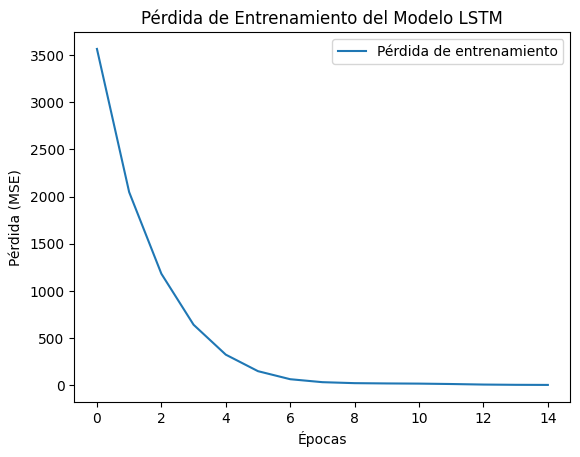

In [122]:
plt.plot(model.history.history['loss'], label='Pérdida de entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (MSE)')
plt.title('Pérdida de Entrenamiento del Modelo LSTM')
plt.legend()
plt.show()

#### Creamos los valores de prediccion
Creamos las predicciones y calculamos el error de cada predicción con respecto al valor real

In [123]:
predictions = model.predict(X)
errors = y - predictions.flatten()
print("Errores: \n", errors)

227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Errores: 
 [ 0.02253197 -0.48384276 -1.00262793 ... -0.78999003 -1.14133388
 -0.19444536]


### b. Detección de anomalías

#### Threshold y deteccion de anomalias
Aquí usando el **rango intercuartílico** y usando el errror de la predicción usado antes, marcamos todos los puntos que esten 1.5 veces alejados de dicho rango como anomalías. Valores mayores de 1.5 provocaban demasiados falsos positivos.

In [124]:
IRQ_DIFF = 1.5

error_IQR = np.percentile(errors, 75) - np.percentile(errors, 25)
print("Rango Intercuartil de los errores: ", error_IQR)
anomalies = np.where(np.abs(errors) > IRQ_DIFF * error_IQR)[0]
print("Número de anomalías detectadas: ", len(anomalies))
error_df = df.iloc[anomalies]

Rango Intercuartil de los errores:  1.8784074221972702
Número de anomalías detectadas:  492


#### Graficamos anomalias
Graficamos los valores originales junto a las anomalias para observar el resultado final de nuestro modelo.

Observamos que la anomalía principal en el centro del grafico la detecta sin ninguna duda, y pequeños picos anómalos al final de la gráfica también. No detecta ciertos valores que no son demasiado anómalos como los del principio de la gráfica, pero el modelo tiene un buen desempeño para ver anomalías grandes.

El numero de anomalias es 492 de 7267
                timestamp      value
85    2013-07-07 13:00:00  65.009244
87    2013-07-07 15:00:00  64.258319
89    2013-07-07 17:00:00  64.143105
90    2013-07-07 18:00:00  64.175942
303   2013-07-16 15:00:00  73.688135
...                   ...        ...
7215  2014-05-26 12:00:00  72.026925
7225  2014-05-26 22:00:00  69.023778
7226  2014-05-26 23:00:00  68.511095
7236  2014-05-27 09:00:00  66.869879
7250  2014-05-27 23:00:00  68.986959

[492 rows x 2 columns]


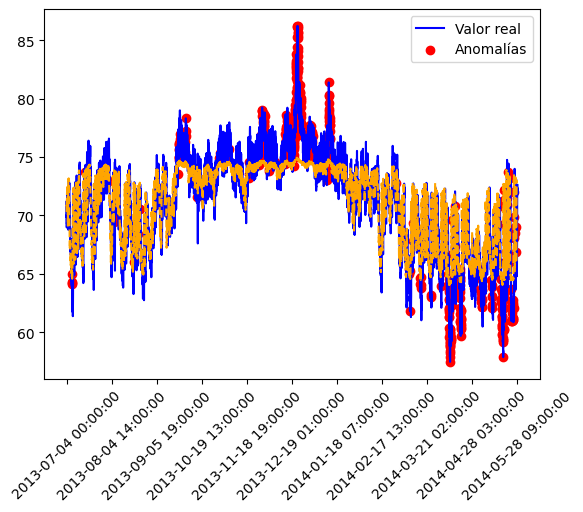

In [125]:
print(f"El numero de anomalias es {len(anomalies)} de {len(df)}")
print(df.iloc[anomalies])
plt.plot(df['timestamp'], df['value'], label='Valor real', color='blue')
plt.plot(predictions, linestyle='dashed', color='orange')
plt.scatter(
    df['timestamp'][anomalies],
    df['value'][anomalies],
    color='red',
    label='Anomalías')
plt.xticks(df['timestamp'][::len(df)//10], rotation=45)
plt.legend()
plt.show()

### c. Mejora del modelo
Los cambios que he aplicado para mejorar el modelo son los siguientes:

Principales:
- Reducir numero de epochs 50 -> 15
- Aumentar tamaño de ventana 3 -> 12

Adicionales:
- Neuronas LSTM 50 -> 100
- Funcion de activación 'tanh' -> 'sigmoid'

## 2. Autoencoder

#### Carga de datos
- Cargamos los datos como antes. 
- Creamos una division para tener datos de entrenamiento y de validacion (Entrenamiento 80% - Validación 20%).
- Escalar los valores a un rango de [0,1] para mejorar nuestro modelo, ya que mejoraba drasticamente el resultado final.

In [126]:
df = pd.read_csv("datos.csv",parse_dates=['timestamp'], index_col='timestamp')
df = df.sort_index()

train_size = int(len(df) * 0.8)
train_df, test_df = df.iloc[:train_size].copy(), df.iloc[train_size:].copy()

min_train, max_train = train_df['value'].min(), train_df['value'].max()
range_train = max_train - min_train

scaler = MinMaxScaler(feature_range=(0, 1))

scaler.fit(train_df[['value']])

train_df['value_scaled'] = scaler.transform(train_df[['value']])
test_df['value_scaled'] = scaler.transform(test_df[['value']])

print(f"Datos de entrenamiento: {len(train_df)}, Datos de prueba: {len(test_df)}")

print("Datos Entrenamiento: \n", train_df.head(5))
print("Datos Prueba: \n", test_df.head(5))

Datos de entrenamiento: 5813, Datos de prueba: 1454
Datos Entrenamiento: 
                          value  value_scaled
timestamp                                   
2013-07-04 00:00:00  69.880835      0.351739
2013-07-04 01:00:00  71.220227      0.404869
2013-07-04 02:00:00  70.877805      0.391286
2013-07-04 03:00:00  68.959400      0.315188
2013-07-04 04:00:00  69.283551      0.328046
Datos Prueba: 
                          value  value_scaled
timestamp                                   
2014-03-21 07:00:00  66.182459      0.205034
2014-03-21 08:00:00  66.263860      0.208263
2014-03-21 09:00:00  68.223849      0.286010
2014-03-21 10:00:00  69.164278      0.323315
2014-03-21 11:00:00  69.109300      0.321134


#### Creacion de ventanas temporales
- Creamos ventanas diferentes para el entrenamiento y validacion.
- En este caso tras varias pruebas tambien me ha funcionado muy bien un tamaño de ventana de 12, consiguiendo una perdida de 0.2 mae aprox.

In [127]:
n_steps = 12

train_data = train_df['value_scaled'].values
test_data = test_df['value_scaled'].values

X_train = np.lib.stride_tricks.sliding_window_view(train_data, window_shape=(n_steps)).copy()
X_test = np.lib.stride_tricks.sliding_window_view(test_data, window_shape=(n_steps)).copy()

print("Dimensiones X_train original: ", X_train.shape)
print("Dimensiones X_test original: ", X_test.shape)

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

y_train = X_train
y_test = X_test


print("\n--- Dimensiones para el modelo ---")
print("X_train Shape: ", X_train.shape)
print("y_train Shape: ", y_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_test Shape: ", y_test.shape)

Dimensiones X_train original:  (5802, 12)
Dimensiones X_test original:  (1443, 12)

--- Dimensiones para el modelo ---
X_train Shape:  (5802, 12, 1)
y_train Shape:  (5802, 12, 1)
X_test Shape:  (1443, 12, 1)
y_test Shape:  (1443, 12, 1)


#### Creamos el autoencoder
- He decidido usar un cuello de botella de 16, ya que en un principio puse 50 y descubir que habia que usar uno mucho mas pequeño para mi caso concreto
- Importante tambien el cambio al mae con respecto al ejercicio 1, este es mucho mejor para no ajustar el modelo a los outliers.

In [128]:
BOTTLENECK_SIZE = 16

inputs = Input(shape=(n_steps, 1))
encoded = LSTM(BOTTLENECK_SIZE, activation='tanh')(inputs)
decoded = RepeatVector(n_steps)(encoded)
decoded = LSTM(BOTTLENECK_SIZE, activation='tanh', return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(1))(decoded)

autoencoder = Model(inputs=inputs, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mae')

autoencoder.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 12, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 16)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_4 (RepeatVector)  │ (None, 12, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 12, 16)         │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 12, 1)          │            17 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,281 (12.82 KB)

 Trainable params: 3,281 (12.82 KB)

 Non-trainable params: 0 (0.00 B)

#### Entrenamos el modelo
Ajustamos el modelo con los datos de prueba y validacion y en este caso si que merece la pena usar 50 epochs. La diferencia de tener un conjunto de datos de validación se nota muchisimo en el resultado final.

In [129]:
epochs = 50
history = autoencoder.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=epochs, batch_size=32,
                        shuffle=False,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

Epoch 1/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0937 - val_loss: 0.0677
Epoch 2/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0515 - val_loss: 0.0528
Epoch 3/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0363 - val_loss: 0.0480
Epoch 4/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0344 - val_loss: 0.0477
Epoch 5/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0342 - val_loss: 0.0474
Epoch 6/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0340 - val_loss: 0.0472
Epoch 7/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0338 - val_loss: 0.0470
Epoch 8/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0334 - val_loss: 0.0466
Epoch 9/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0328 - val_loss: 0.0460
Epoch 10/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0319 - val_loss: 0.0448
Epoch 11/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0300 - val_loss: 0.0413
Epoch 12/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 

#### Predictions
- Creo las predicciones del modelo de datos y validacion, y creo nuevos dataframes para guardar los resultados de las predicciones, y si son anomalias o no.
- He cambiado el criterio de detección de nomalías a un percentil del 99%, en vez del rango intercuartílico, y tambien da buenos resultados

In [130]:
predictions_train = autoencoder.predict(X_train)
predictions_test = autoencoder.predict(X_test)

mae_train = np.mean(np.abs(predictions_train - X_train), axis=(1,2))
mae_test = np.mean(np.abs(predictions_test - X_test), axis=(1,2))

print("\n--- Formas de MAE ---")
print("MAE Train: ", mae_train.shape)
print("MAE Test: ", mae_test.shape)

threshold = np.percentile(mae_train, 99)

print(f"Umbral de MAE para anomalías (99 percentil): {threshold:.4f}")

pred_last_step_train = predictions_train[:, -1, :]
pred_last_step_test = predictions_test[:, -1, :]

pred_original_scale_train = scaler.inverse_transform(pred_last_step_train)
pred_original_scale_test = scaler.inverse_transform(pred_last_step_test)

train_scores_df = pd.DataFrame(index=train_df.index[n_steps-1:])
train_scores_df['mae'] = mae_train
train_scores_df['threshold'] = threshold
train_scores_df['anomaly'] = train_scores_df['mae'] > train_scores_df['threshold']
train_scores_df['value'] = train_df['value'][n_steps - 1:]
train_scores_df['predicted'] = pred_original_scale_train

test_scores_df = pd.DataFrame(index=test_df.index[n_steps - 1:])
test_scores_df['mae'] = mae_test
test_scores_df['threshold'] = threshold
test_scores_df['anomaly'] = test_scores_df['mae'] > test_scores_df['threshold']
test_scores_df['value'] = test_df['value'][n_steps - 1:]
test_scores_df['predicted'] = pred_original_scale_test

all_scores_df = pd.concat([train_scores_df, test_scores_df])

print("\nAnomalías en datos de entrenamiento:", train_scores_df['anomaly'].sum())
print("\nAnomalías en datos de prueba:", test_scores_df['anomaly'].sum())

print("\n--- Anomalías detectadas en datos de prueba ---")
print(test_scores_df[test_scores_df['anomaly']].head(5))

182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

--- Formas de MAE ---
MAE Train:  (5802,)
MAE Test:  (1443,)
Umbral de MAE para anomalías (99 percentil): 0.0319

Anomalías en datos de entrenamiento: 59

Anomalías en datos de prueba: 87

--- Anomalías detectadas en datos de prueba ---
                          mae  threshold  anomaly      value  predicted
timestamp                                                              
2014-03-24 19:00:00  0.053745   0.031876     True  71.943363  67.560936
2014-03-24 20:00:00  0.061393   0.031876     True  70.715643  68.805573
2014-03-24 21:00:00  0.053861   0.031876     True  69.288119  69.389671
2014-03-24 22:00:00  0.055440   0.031876     True  68.437863  69.465775
2014-03-24 23:00:00  0.058259   0.031876     True  68.249350  69.204910


#### Graficamos anomalias
Graficamos las anomalias de la misma manera que en el modelo anterior

El numero de anomalias es  146  de  7245
                         value
timestamp                     
2013-08-06 20:00:00  65.260177
2013-08-06 21:00:00  74.762234
2013-08-06 22:00:00  73.495254
2013-08-06 23:00:00  73.365385
2013-08-07 00:00:00  72.597673
...                        ...
2014-05-27 19:00:00  71.490228
2014-05-28 11:00:00  72.370206
2014-05-28 12:00:00  72.172956
2014-05-28 13:00:00  72.046565
2014-05-28 14:00:00  71.825226

[146 rows x 1 columns]


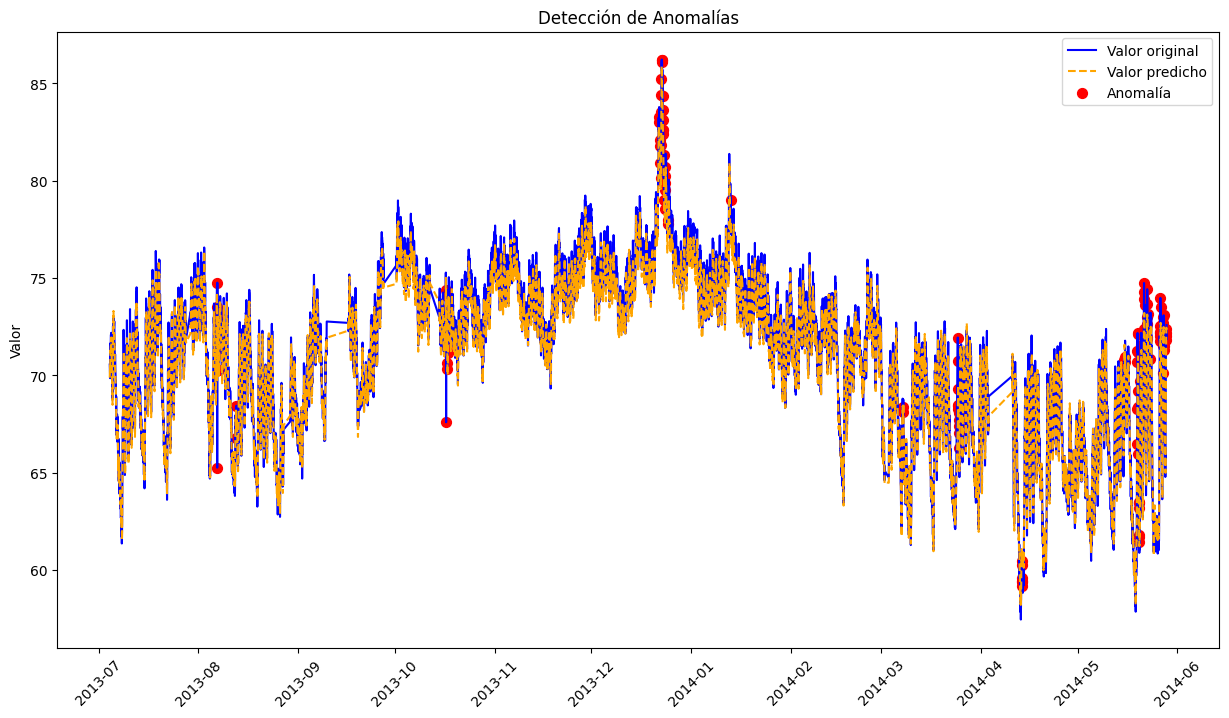

In [131]:
anomalies_df = all_scores_df[all_scores_df['anomaly']]
print("El numero de anomalias es ", len(anomalies_df), " de ", len(all_scores_df))
print(anomalies_df[['value']])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8), sharex=True)

ax.set_title("Detección de Anomalías")
ax.plot(
    all_scores_df.index,
    all_scores_df['value'],
    label='Valor original',
    color='blue'
)
ax.plot(
    all_scores_df.index,
    all_scores_df['predicted'],
    label='Valor predicho',
    color='orange',
    linestyle='dashed'
)
ax.scatter(
    anomalies_df.index,
    anomalies_df['value'],
    label='Anomalía',
    color='red',
    marker='o',
    s=50
)
ax.legend()
ax.set_ylabel('Valor')
plt.xticks(rotation=45)
plt.show()

### Mejoras implementadas
- He usado en este caso un MinMaxScaler, para poder escalar los valores para que el autoencoder funcione mejor, y despues poder desescalarlos y ver la prediccion real de mi modelo.
- El tamaño de ventana lo he mantenido a 12, lo cual me ha dado muy buenos resultados en esta ocasión también
- He usado el mae en vez de el mse, ya que este ultimo penalizaba al modelo mucho por las anomalias y no hacia buenas predicciones.
- Y para el autoencoder he usado la funcion tanh predecia mejor, junto a un bottleneck de 16

## 3.Isolation Forest

### Cargamos y preparamos los datos
Aqui creo el dataframe como en los 2 ejercicios anteriores

In [132]:
df = pd.read_csv("datos.csv",parse_dates=['timestamp'], index_col='timestamp')
df = df.sort_index()

print("Datos cargados y ordenados: \n", df.head(5))
print(f"Total de datos: {len(df)}")

Datos cargados y ordenados: 
                          value
timestamp                     
2013-07-04 00:00:00  69.880835
2013-07-04 01:00:00  71.220227
2013-07-04 02:00:00  70.877805
2013-07-04 03:00:00  68.959400
2013-07-04 04:00:00  69.283551
Total de datos: 7267


### Creamos las ventanas y preparamos df de resultados
- Aqui creo las ventanas como siempre y creo el dataframe de resultados final
- El tamaño de ventana lo he mantenido en 12 ya que sigue funcionando muy bien.

In [133]:
n_steps = 12

X_data = np.lib.stride_tricks.sliding_window_view(df["value"], window_shape=(n_steps))

print("Dimensiones de ventanas: ", X_data.shape)

df_results = pd.DataFrame({
	'value': df['value'][n_steps - 1:],
}, index=df.index[n_steps - 1:])

Dimensiones de ventanas:  (7256, 12)


### Creamos modelo de IsolationForest
- Los estimadores no he encontrado casi diferencia al aumentarlos en este caso, siemplemente tarda mas el modelo.
- La contaminacion si que se nota mucho, con valores mas bajos como 0.05 o menos detectaba solo las anomalias mas exageradas. Con 0.1 detecta bastantes mas que son mas sutiles, y creo que en este contexto de un meidor de temperatura, no pasa nada por aumentar mas falsos positivos.

In [134]:
n_estimators = 100
contamination = 0.1

iso_forest = IsolationForest(n_estimators=n_estimators, contamination=contamination, random_state=42)

### Entrenamos y predecimos los valores del modelo
- Entreno predigo y almaceno los valores que ha obtenido el IsolationForest, marcando si son anomalias o no

In [135]:
predictions = iso_forest.fit_predict(X_data)
scores = iso_forest.decision_function(X_data)

df_results['anomaly'] = predictions == -1
df_results['anomaly_score'] = scores

### Graficamos las anomalias detectadas
Graficamos las anomalias y el grafico original como siempre

El numero de anomalias es 726 de 7256
                         value
timestamp                     
2013-07-07 23:00:00  64.246634
2013-07-08 01:00:00  62.030554
2013-07-08 02:00:00  63.411560
2013-07-08 03:00:00  61.705110
2013-07-08 04:00:00  62.775139
...                        ...
2014-05-27 13:00:00  72.680780
2014-05-27 14:00:00  71.968614
2014-05-27 15:00:00  72.114432
2014-05-27 16:00:00  73.007830
2014-05-27 17:00:00  73.087685

[726 rows x 1 columns]


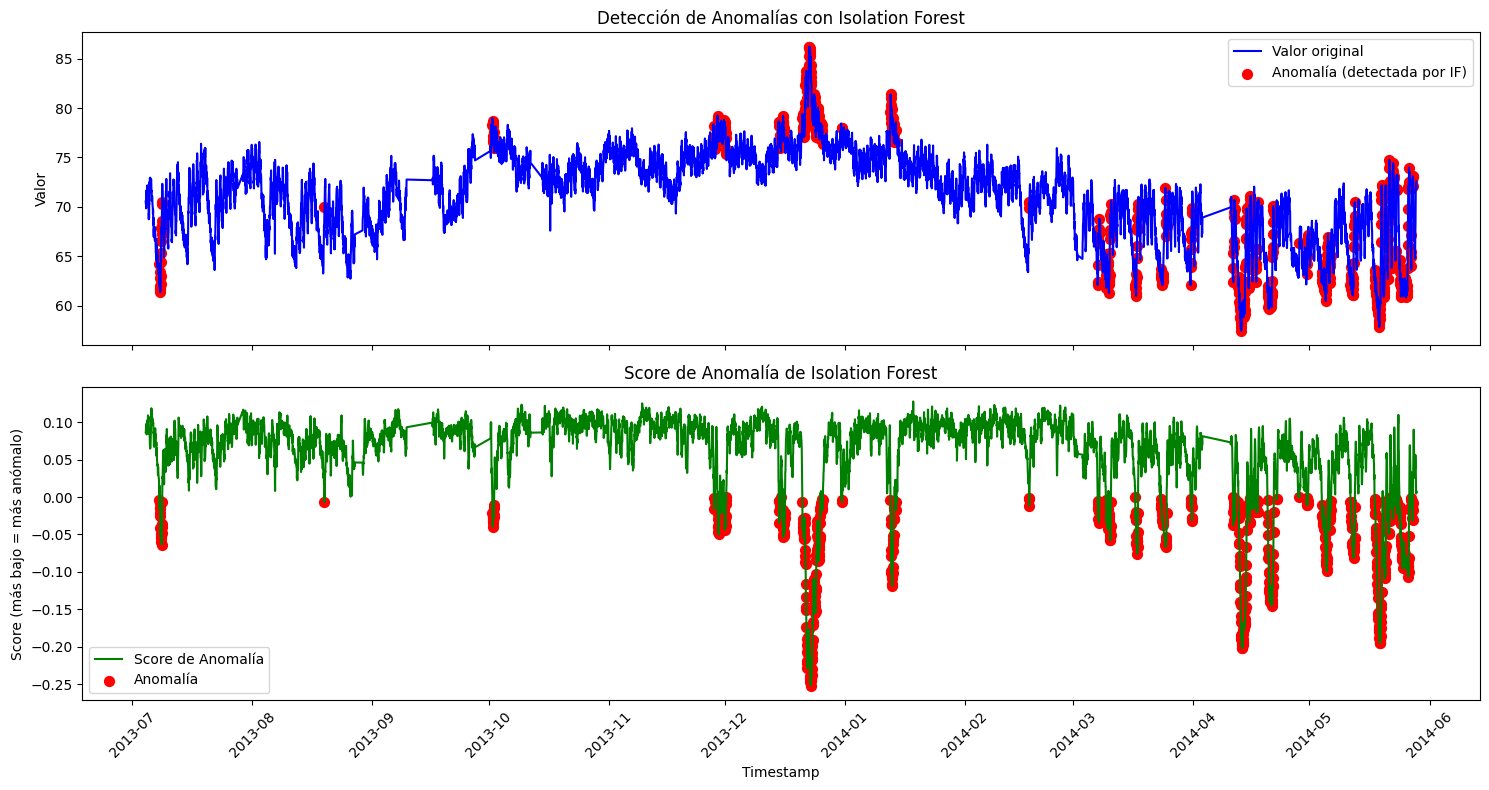

In [136]:
anomalies_df = df_results[df_results['anomaly']]
print(f"El numero de anomalias es {len(anomalies_df)} de {len(df_results)}")
print(anomalies_df[['value']])

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 8), sharex=True)

ax[0].set_title("Detección de Anomalías con Isolation Forest")
ax[0].plot(
    df_results.index, 
    df_results['value'], 
    label='Valor original', 
    color='blue'
)
ax[0].scatter(
    anomalies_df.index, 
    anomalies_df['value'], 
    label='Anomalía (detectada por IF)', 
    color='red', 
    marker='o',
    s=50
)
ax[0].legend()
ax[0].set_ylabel('Valor')

ax[1].set_title("Score de Anomalía de Isolation Forest")
ax[1].plot(
    df_results.index, 
    df_results['anomaly_score'], 
    label='Score de Anomalía', 
    color='green'
)
ax[1].scatter(
    anomalies_df.index, 
    anomalies_df['anomaly_score'],
    label='Anomalía',
    color='red',
    marker='o',
    s=50
)
ax[1].legend()
ax[1].set_ylabel('Score (más bajo = más anómalo)')
ax[1].set_xlabel('Timestamp')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()